# Point Cloud Alignment Example

Two examples that align two point clouds with known correspondences with one using trajectory interpolation to handle motion
distortion.


In [1]:
import numpy as np
np.set_printoptions(6, suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib widget
from pylgmath import cmnop, se3op, Transformation
from pysteam.evaluable import se3 as se3ev
from pysteam.evaluable.vspace import VSpaceStateVar
from pysteam.evaluable.p2p import P2PErrorEvaluator
from pysteam import problem, solver, trajectory

## Point Cloud Alignment Without Motion Distortion

Create a fake point cloud with 360 degree horizontal FOV and 90 degree vertical FOV:


In [2]:
# horizontal and vertical resolution
hori_res = np.pi / 6
vert_res = np.pi / 24
# horizontal and vertical degrees in radian
phis = np.arange(0, 2 * np.pi, hori_res)
thetas = np.arange(0, np.pi / 2 + 1e-5, vert_res)
# tile and repeat to create lidar scans
fullphis = np.repeat(phis, len(thetas))
fullthetas = np.tile(thetas, len(phis))
fullrhos = np.random.uniform(10, 10, fullthetas.shape)
# create reference point cloud
ref_pts_polar = np.stack((fullrhos, fullthetas, fullphis), axis=-1)
ref_pts_polar = ref_pts_polar[..., None]
ref_pts_cart = cmnop.pol2cart(ref_pts_polar)
ref_points = np.concatenate((ref_pts_cart, np.ones((ref_pts_cart.shape[0], 1, 1))), axis=-2)

Transform this point cloud to the query frame, say the vehicle frame, without motion distortion:


In [3]:
# ground truth transformation
T_10 = se3op.vec2tran(np.array([[-2.2, 0., 0., 0., 0., 0.44]]).T)
# transform point cloud
qry_points = T_10 @ ref_points
# correspondences
sample_inds = np.array([np.arange(qry_points.shape[0]), np.arange(qry_points.shape[0])]).T

Set up point cloud alignment as an optimization problem and solve:


In [4]:
# State to be estimated with initial condition
hat_T_10 = Transformation()

# Set up state variable
T_10_var = se3ev.SE3StateVar(hat_T_10)  # wrap as a state variable

## Set up shared noise and loss function
noise_model = problem.StaticNoiseModel(np.eye(3))
loss_func = problem.L2LossFunc()

## Setup cost terms
cost_terms = []
for i in range(qry_points.shape[0]):
  qry_pt = qry_points[sample_inds[i, 0]]
  ref_pt = ref_points[sample_inds[i, 1]]
  error_func = P2PErrorEvaluator(se3ev.inv(T_10_var), ref_pt, qry_pt)
  cost_terms.append(problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func))

## Make optimization problem
opt_prob = problem.OptimizationProblem()
opt_prob.add_state_var(T_10_var)
opt_prob.add_cost_term(*cost_terms)

## Make solver and solve
optimizer = solver.GaussNewtonSolver(opt_prob, verbose=True)
optimizer.optimize()

print("Estimated Transform:     \n", hat_T_10.matrix())
print("Ground Truth Transform:  \n", T_10)
assert np.allclose(hat_T_10.matrix(), T_10)


Begin Optimization
------------------
Number of States:  1
Number of Cost Terms:  156
Initial Cost:  1114.4055403264274
Iteration:    1  -  Cost:    17.4503
Iteration:    2  -  Cost:     0.0008
Iteration:    3  -  Cost:     0.0000
Iteration:    4  -  Cost:     0.0000
Termination Cause:  CONVERGED ABSOLUTE CHANGE
Total Optimization Time: 0.6941 seconds
Estimated Transform:     
 [[ 0.904752 -0.425939 -0.       -2.129697]
 [ 0.425939  0.904752  0.       -0.476242]
 [ 0.       -0.        1.       -0.      ]
 [ 0.        0.        0.        1.      ]]
Ground Truth Transform:  
 [[ 0.904752 -0.425939  0.       -2.129697]
 [ 0.425939  0.904752  0.       -0.476242]
 [ 0.        0.        1.        0.      ]
 [ 0.        0.        0.        1.      ]]


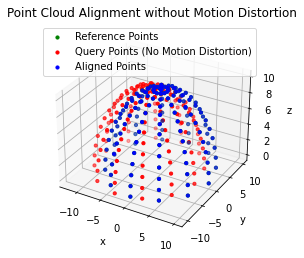

In [5]:
## Get interpolated poses to align point cloud
aligned = hat_T_10.inverse().matrix() @ qry_points

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_title('Point Cloud Alignment without Motion Distortion')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.scatter(ref_points[:, 0, 0], ref_points[:, 1, 0], ref_points[:, 2, 0], s=10, c='g', label='Reference Points')
ax.scatter(qry_points[:, 0, 0],
           qry_points[:, 1, 0],
           qry_points[:, 2, 0],
           s=10,
           c='r',
           label='Query Points (No Motion Distortion)')
ax.scatter(aligned[:, 0, 0], aligned[:, 1, 0], aligned[:, 2, 0], s=10, c='b', label='Aligned Points')
ax.legend()
plt.show()

## Point Cloud Alignment With Motion Distortion

Create a fake point cloud with 360 degree horizontal FOV and 90 degree vertical FOV:


In [6]:
# horizontal and vertical resolution
hori_res = np.pi / 6
vert_res = np.pi / 24
# horizontal and vertical degrees in radian
phis = np.arange(0, 2 * np.pi, hori_res)
thetas = np.arange(0, np.pi / 2 + 1e-5, vert_res)
# tile and repeat to create lidar scans
fullphis = np.repeat(phis, len(thetas))
fullthetas = np.tile(thetas, len(phis))
fullrhos = np.random.uniform(10, 10, fullthetas.shape)
# create reference point cloud
ref_pts_polar = np.stack((fullrhos, fullthetas, fullphis), axis=-1)
ref_pts_polar = ref_pts_polar[..., None]
ref_pts_cart = cmnop.pol2cart(ref_pts_polar)
ref_points = np.concatenate((ref_pts_cart, np.ones((ref_pts_cart.shape[0], 1, 1))), axis=-2)


Create a motion distorted point cloud in query frame, say the vehicle frame:


In [7]:
# number of state times
num_meas_poses = len(phis)
# setup velocity prior
delt = 0.1
velocity_prior = np.array([[-2.0, 0., 0., 0., 0., 0.4]]).T
init_pose_vec = np.array([[0., 0., 0., 0., 0., 0.]]).T
init_pose = Transformation(xi_ab=init_pose_vec)
total_time = delt * (num_meas_poses - 1)
# ground truth poses at measurements
T_k0 = [se3op.vec2tran(i * delt * velocity_prior) @ init_pose.matrix() for i in range(num_meas_poses)]
# measurement times of each point
ts = np.repeat(np.array([i * delt for i in range(num_meas_poses)]), len(thetas))
# distorted point cloud
qry_points = np.copy(ref_points)
for i, T in enumerate(T_k0):
  qry_points[i * len(thetas):(i + 1) * len(thetas)] = (T @ qry_points[i * len(thetas):(i + 1) * len(thetas)])
# correspondences
sample_inds = np.array([np.arange(qry_points.shape[0]), np.arange(qry_points.shape[0])]).T

In [8]:
# Set up states with initial guesses
hat_T_00 = Transformation(xi_ab=np.array([[0., 0., 0., 0., 0., 0.]]).T)
hat_w_00_in0 = np.zeros((6, 1))
hat_T_10 = Transformation(xi_ab=np.array([[0., 0., 0., 0., 0., 0.]]).T)
hat_w_01_in1 = np.zeros((6, 1))
# only need two pose and velocity states
T_00_var = se3ev.SE3StateVar(hat_T_00, locked=True)
w_00_in0_var = VSpaceStateVar(hat_w_00_in0)
T_10_var = se3ev.SE3StateVar(hat_T_10)
w_01_in1_var = VSpaceStateVar(hat_w_01_in1)

## Setup trajectory
Qc_inv = np.diag(1 / np.array([1.0, 0.001, 0.001, 0.001, 0.001, 1.0]))  # smoothing factor diagonal
traj = trajectory.const_vel.Interface(Qc_inv=Qc_inv)
traj.add_knot(time=trajectory.Time(secs=0), T_k0=T_00_var, w_0k_ink=w_00_in0_var)
traj.add_knot(time=trajectory.Time(secs=total_time), T_k0=T_10_var, w_0k_ink=w_01_in1_var)

## Setup shared noise and loss function
noise_model = problem.StaticNoiseModel(np.eye(3))
loss_func = problem.L2LossFunc()

## Setup cost terms
cost_terms = []
for i in range(qry_points.shape[0]):
  qry_pt = qry_points[sample_inds[i, 0]]
  ref_pt = ref_points[sample_inds[i, 1]]
  T_mq = se3ev.inv(traj.get_pose_interpolator(trajectory.Time(secs=ts[sample_inds[i, 0]])))
  error_func = P2PErrorEvaluator(T_mq, ref_pt, qry_pt)
  cost_terms.append(problem.WeightedLeastSquareCostTerm(error_func, noise_model, loss_func))

## Make optimization problem
opt_prob = problem.OptimizationProblem()
opt_prob.add_state_var(T_00_var, w_00_in0_var, T_10_var, w_01_in1_var)
opt_prob.add_cost_term(*cost_terms)

## Make solver and solve
optimizer = solver.GaussNewtonSolver(opt_prob, verbose=True)
optimizer.optimize()

print("Estimated Pose:     \n", hat_T_10.matrix())
print("Ground Truth Pose:  \n", T_k0[-1])
assert np.allclose(hat_T_10.matrix(), T_k0[-1])

Begin Optimization
------------------
Number of States:  3
Number of Cost Terms:  156
Initial Cost:  218.10741181822448
Iteration:    1  -  Cost:     5.3063
Iteration:    2  -  Cost:     0.0050
Iteration:    3  -  Cost:     0.0000
Iteration:    4  -  Cost:     0.0000
Termination Cause:  CONVERGED ABSOLUTE CHANGE
Total Optimization Time: 3.7345 seconds
Estimated Pose:     
 [[ 0.904752 -0.425939  0.       -2.129697]
 [ 0.425939  0.904752  0.       -0.476242]
 [-0.       -0.        1.        0.      ]
 [ 0.        0.        0.        1.      ]]
Ground Truth Pose:  
 [[ 0.904752 -0.425939  0.       -2.129697]
 [ 0.425939  0.904752  0.       -0.476242]
 [ 0.        0.        1.        0.      ]
 [ 0.        0.        0.        1.      ]]


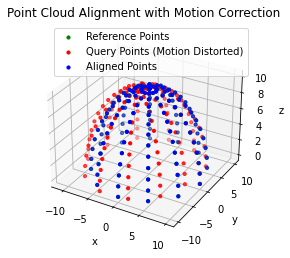

In [9]:
# Get interpolated poses to align point cloud
aligned = np.empty_like(ref_points)
for i in range(ref_points.shape[0]):
  idx = sample_inds[i, 0]
  T_mq = traj.get_pose_interpolator(trajectory.Time(secs=ts[idx])).evaluate().inverse()
  aligned[idx] = T_mq.matrix() @ qry_points[idx]

# Plot if figure is given
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_title('Point Cloud Alignment with Motion Correction')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.scatter(ref_points[:, 0, 0], ref_points[:, 1, 0], ref_points[:, 2, 0], s=10, c='g', label='Reference Points')
ax.scatter(qry_points[:, 0, 0],
           qry_points[:, 1, 0],
           qry_points[:, 2, 0],
           s=10,
           c='r',
           label='Query Points (Motion Distorted)')
ax.scatter(aligned[:, 0, 0], aligned[:, 1, 0], aligned[:, 2, 0], s=10, c='b', label='Aligned Points')
ax.legend()
plt.show()